In [89]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [215]:
# Define some constants
latitude = [40.79736, 41.78701, 30.1444, 25.7738]
longitude = [-73.97785, -87.77166, -97.66876, -80.1936]
cities = ["ny", "il", "tx", "fl"]
start_date = "2016-01-01"
end_date = "2024-03-25"
time_steps = 60

In [211]:
def trainModel(city, name_prefix=""):
  # Step 1: Load your data
  # Assume 'df' is your DataFrame with columns 'date', 'day_of_year', 'tmax', 'tmin', 'precipitation', 'humidity'
  df = pd.read_pickle("./data_cleaned_"+ city +".pkl")
  df['date'] = pd.to_datetime(df['date'])
  df.set_index('date', inplace=True)
  # df.loc[datetime.datetime(2016, 1, 1), datetime.datetime(2024, 2, 29)]

  df['tmax_avg'].plot(figsize=(10,6))
  # plt.show()
  
  df = df.rename(columns={"day": "day_of_year", "tmax_avg":"tmax", "tmin_avg": "tmin", 'prec_om': "prec", 'humi_vc': "humi"})
#   df.info()
  features = ['day_of_year', 'tmax', 'tmin', 'prec', 'humi']
  df = df[features]

  df.fillna(df.mean(), inplace=True)

  target = 'tmax'
  # Normalize the features
  scaler = StandardScaler()
  df_scaled = scaler.fit_transform(df[features])

  # Function to create a dataset for LSTM
  def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

  # Use this many days of data to predict the next day's 'tmax'
  X, y = create_dataset(df_scaled, df_scaled[:, 1], time_steps)
  split = int(len(X) * 0.80) 

  # Split the data
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  
  early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=10,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,           # Log when training is stopped
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity.

  # LSTM model
  # model = Sequential()
  # # model.add(LSTM(70, activation='relu', input_shape=(time_steps, X.shape[2])))
  # model.add(LSTM(128, activation='relu', input_shape=(time_steps, X.shape[2]), return_sequences=True))
  # model.add(Dropout(0.2))
  # model.add(LSTM(64, activation='relu', return_sequences=True))
  # model.add(Dropout(0.2))
  # model.add(LSTM(32, activation='relu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(1))
  # model.compile(optimizer=Adam(0.001), loss='mean_squared_error')
  
  # model = Sequential()
  # # # First LSTM layer with Dropout
  # # model.add(LSTM(128, activation='relu', input_shape=(time_steps, X.shape[2]), return_sequences=True))
  # # model.add(Dropout(0.2))

  # # model.add(LSTM(64, activation='relu', return_sequences=True))
  # # model.add(Dropout(0.2))

  # # # model.add(LSTM(32, activation='relu', return_sequences=True))
  # # # model.add(Dropout(0.2))

  # # model.add(LSTM(64, activation='relu'))
  # # model.add(Dropout(0.2))

  # # # Output layer with a single neuron for regression output
  # # model.add(Dense(1))

  # # model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

  model = Sequential()
  model.add(LSTM(70, activation='relu', input_shape=(time_steps, X.shape[2])))
  model.add(Dense(1))
  model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

  # Train the model
  # model.fit(X_train, y_train, epochs=47, batch_size=32, validation_split=0.2, verbose=1)
  # 80, no early, time step 10
  model.fit(X_train, y_train, epochs=47, batch_size=32, validation_split=0.2, verbose=1)

  # Evaluate the model
  mse = model.evaluate(X_test, y_test, verbose=0)
  print(f'Test MSE: {mse}')
  model.save(name_prefix + "model_" + city + '.keras')
  # Predictions
  predictions = model.predict(X_test)

In [182]:
def getPrediction(city, name_prefix="", offset=0):
    model = tf.keras.models.load_model(name_prefix + 'model_'+city+'.keras')
    df = pd.read_pickle("./prediction_data_cleaned_"+ city +".pkl")
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df.rename(columns={"day": "day_of_year", "tmax_avg":"tmax", "tmin_avg": "tmin", 'prec_om': "prec", 'humi_vc': "humi"})
    # df.info()
    features = ['day_of_year', 'tmax', 'tmin', 'prec', 'humi']
    df = df[features]
    target = 'tmax'

    # Normalize the features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])

    # Use this many days of data to predict the next day's 'tmax'
    # X, y = create_dataset(df_scaled, df_scaled[:, 1], time_steps)
    # split = int(len(X) * 0.75)  # 70% for training

    # # Split the data
    # X_train, X_test = X[:split], X[split:]
    # y_train, y_test = y[:split], y[split:]
    old_data = df[-(time_steps):]
    if offset != 0:
        old_data = df[-(time_steps+offset):-offset]
    old_data.fillna(old_data.mean(), inplace=True)
    
    last_days_data = np.array(old_data)
    # print(last_days_data)
    last_days_scaled = scaler.transform(last_days_data)
    last_days_scaled = np.expand_dims(last_days_scaled, axis=0)
    predicted_tmax_scaled = model.predict(last_days_scaled)
    dummy_array = np.zeros((1, len(features))) 
    dummy_array[:, 1] = predicted_tmax_scaled
    inverse_transformed_array = scaler.inverse_transform(dummy_array)
    predicted_tmax = inverse_transformed_array[:, 1]

    print(f"Predicted 'tmax' for {city} for next day: {predicted_tmax[0]}")

Epoch 1/47


/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.4406 - val_loss: 0.2022
Epoch 2/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1794 - val_loss: 0.1715
Epoch 3/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1748 - val_loss: 0.1597
Epoch 4/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1543 - val_loss: 0.1538
Epoch 5/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1458 - val_loss: 0.1466
Epoch 6/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1460 - val_loss: 0.1373
Epoch 7/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1361 - val_loss: 0.1335
Epoch 8/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1246 - val_loss: 0.1291
Epoch 9/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1268 - val_loss: 0.1283
Epoch 10/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1269 - val_loss: 0.1279
Epoch 11/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1331 - val_loss: 0.1292
Epoch 12/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1221 - val_l

/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_39380/390500586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_data.fillna(old_data.mean(), inplace=True)
/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicted 'tmax' for ny for next day: 54.66289714615109


/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_39380/390500586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_data.fillna(old_data.mean(), inplace=True)
/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Predicted 'tmax' for ny for next day: 52.73357945480798


/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_39380/390500586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_data.fillna(old_data.mean(), inplace=True)
/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Predicted 'tmax' for ny for next day: 51.555956782860726


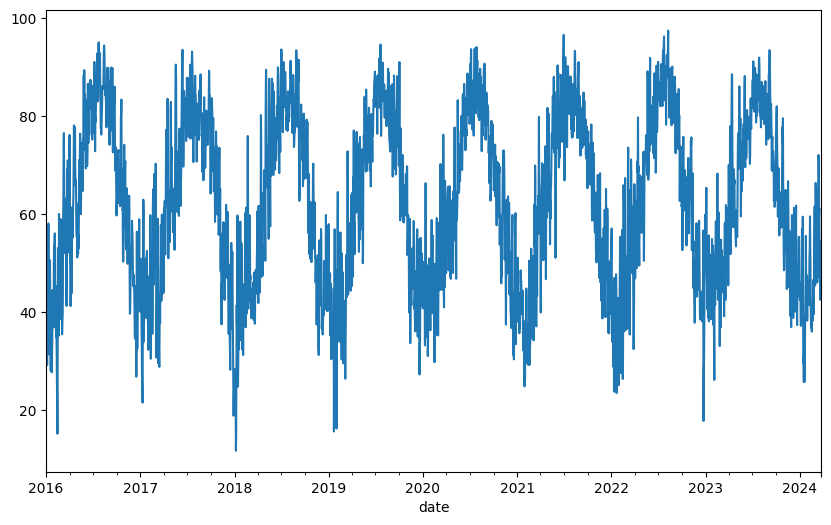

In [212]:
trainModel(cities[0], "exp")
getPrediction(cities[0], "exp")
getPrediction(cities[0], "exp", 1)
getPrediction(cities[0], "exp", 2)
# getPrediction(cities[0], "exp", 3)
# getPrediction(cities[0], "exp", 4)

Epoch 1/47


/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.5152 - val_loss: 0.1790
Epoch 2/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1841 - val_loss: 0.1693
Epoch 3/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1652 - val_loss: 0.1558
Epoch 4/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1569 - val_loss: 0.1523
Epoch 5/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1407 - val_loss: 0.1434
Epoch 6/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1447 - val_loss: 0.1428
Epoch 7/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1485 - val_loss: 0.1325
Epoch 8/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1291 - val_loss: 0.1331
Epoch 9/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1342 - val_loss: 0.1371
Epoch 10/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1272 - val_loss: 0.1281
Epoch 11/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1308 - val_loss: 0.1324
Epoch 12/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1365 - val_l

/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.4631 - val_loss: 0.1813
Epoch 2/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1616 - val_loss: 0.1677
Epoch 3/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1416 - val_loss: 0.1517
Epoch 4/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1288 - val_loss: 0.1416
Epoch 5/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1193 - val_loss: 0.1269
Epoch 6/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1307 - val_loss: 0.1335
Epoch 7/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1125 - val_loss: 0.1272
Epoch 8/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1089 - val_loss: 0.1273
Epoch 9/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1049 - val_loss: 0.1185
Epoch 10/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1123 - val_loss: 0.1184
Epoch 11/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1054 - val_loss: 0.1123
Epoch 12/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0938 - val_l

/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.4146 - val_loss: 0.1896
Epoch 2/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2265 - val_loss: 0.1646
Epoch 3/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2169 - val_loss: 0.1640
Epoch 4/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1885 - val_loss: 0.1682
Epoch 5/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1847 - val_loss: 0.1353
Epoch 6/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1693 - val_loss: 0.1283
Epoch 7/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1667 - val_loss: 0.1194
Epoch 8/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1556 - val_loss: 0.1195
Epoch 9/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1552 - val_loss: 0.1203
Epoch 10/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1630 - val_loss: 0.1143
Epoch 11/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1535 - val_loss: 0.1145
Epoch 12/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1450 - val_l

/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.5644 - val_loss: 0.2047
Epoch 2/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2892 - val_loss: 0.1948
Epoch 3/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2484 - val_loss: 0.1756
Epoch 4/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2239 - val_loss: 0.1985
Epoch 5/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2479 - val_loss: 0.1750
Epoch 6/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2169 - val_loss: 0.1723
Epoch 7/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2026 - val_loss: 0.1719
Epoch 8/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2145 - val_loss: 0.1618
Epoch 9/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1958 - val_loss: 0.1569
Epoch 10/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1925 - val_loss: 0.1528
Epoch 11/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1995 - val_loss: 0.1499
Epoch 12/47
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1901 - val_l

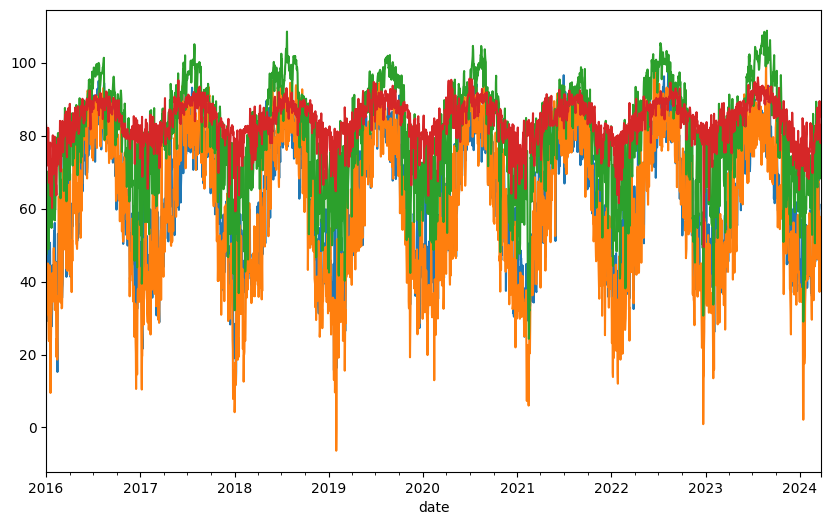

In [200]:
for city in cities:
  trainModel(city, "exp")
  # break # temp

In [216]:
for city in cities:
  getPrediction(city)

/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_39380/390500586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_data.fillna(old_data.mean(), inplace=True)
/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Predicted 'tmax' for ny for next day: 51.19467539356033


/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_39380/390500586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_data.fillna(old_data.mean(), inplace=True)
/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Predicted 'tmax' for il for next day: 68.62029180633594


/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_39380/390500586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_data.fillna(old_data.mean(), inplace=True)
/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted 'tmax' for tx for next day: 74.94916608231705


/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_39380/390500586.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_data.fillna(old_data.mean(), inplace=True)
/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Predicted 'tmax' for fl for next day: 84.07325738289968
